In [1]:
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt

from zipfile import ZipFile
from urllib.request import urlretrieve

from IPython.display import HTML
from matplotlib.animation import FuncAnimation

from IPython.display import YouTubeVideo, display, HTML
from base64 import b64encode

%matplotlib inline

In [2]:
def download_and_unzip(url, save_path):
    print(f"Downloading and extracting assests....", end="")

    # Downloading zip file using urllib package.
    urlretrieve(url, save_path)

    try:
        # Extracting zip file using the zipfile package.
        with ZipFile(save_path) as z:
            # Extract ZIP file contents in the same directory.
            z.extractall(os.path.split(save_path)[0])

        print("Done")

    except Exception as e:
        print("\nInvalid file.", e)

In [3]:
URL = r"https://www.dropbox.com/s/ld535c8e0vueq6x/opencv_bootcamp_assets_NB11.zip?dl=1"

asset_zip_path = os.path.join(os.getcwd(), "opencv_bootcamp_assets_NB11.zip")

# Download if assest ZIP does not exists.
if not os.path.exists(asset_zip_path):
    download_and_unzip(URL, asset_zip_path)

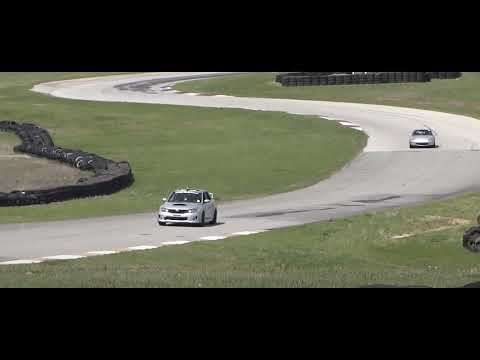

In [5]:
video = YouTubeVideo("XkJCvtCRdVM", width=1024, height=640)
display(video)

In [6]:
video_input_file_name = "race_car.mp4"


def drawRectangle(frame, bbox):
    p1 = (int(bbox[0]), int(bbox[1]))
    p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
    cv2.rectangle(frame, p1, p2, (255, 0, 0), 2, 1)


def displayRectangle(frame, bbox):
    plt.figure(figsize=(20, 10))
    frameCopy = frame.copy()
    drawRectangle(frameCopy, bbox)
    frameCopy = cv2.cvtColor(frameCopy, cv2.COLOR_RGB2BGR)
    plt.imshow(frameCopy)
    plt.axis("off")


def drawText(frame, txt, location, color=(50, 170, 50)):
    cv2.putText(frame, txt, location, cv2.FONT_HERSHEY_SIMPLEX, 1, color, 3)

In [7]:
tracker_types = [
    "BOOSTING",
    "MIL",
    "KCF",
    "CSRT",
    "TLD",
    "MEDIANFLOW",
    "GOTURN",
    "MOSSE",
]

# Change the index to change the tracker type
tracker_type = tracker_types[2]

if tracker_type == "BOOSTING":
    tracker = cv2.legacy.TrackerBoosting.create()
elif tracker_type == "MIL":
    tracker = cv2.legacy.TrackerMIL.create()
elif tracker_type == "KCF":
    tracker = cv2.TrackerKCF.create()
elif tracker_type == "CSRT":
    tracker = cv2.TrackerCSRT.create()
elif tracker_type == "TLD":
    tracker = cv2.legacy.TrackerTLD.create()
elif tracker_type == "MEDIANFLOW":
    tracker = cv2.legacy.TrackerMedianFlow.create()
elif tracker_type == "GOTURN":
    tracker = cv2.TrackerGOTURN.create()
else:
    tracker = cv2.legacy.TrackerMOSSE.create()

In [8]:
video = cv2.VideoCapture(video_input_file_name)
ok, frame = video.read()

# Exit if video not opened
if not video.isOpened():
    print("Could not open video")
    sys.exit()
else:
    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))

video_output_file_name = "race_car-" + tracker_type + ".mp4"
video_out = cv2.VideoWriter(video_output_file_name, cv2.VideoWriter_fourcc(*"XVID"), 10, (width, height))

video_output_file_name

'race_car-KCF.mp4'

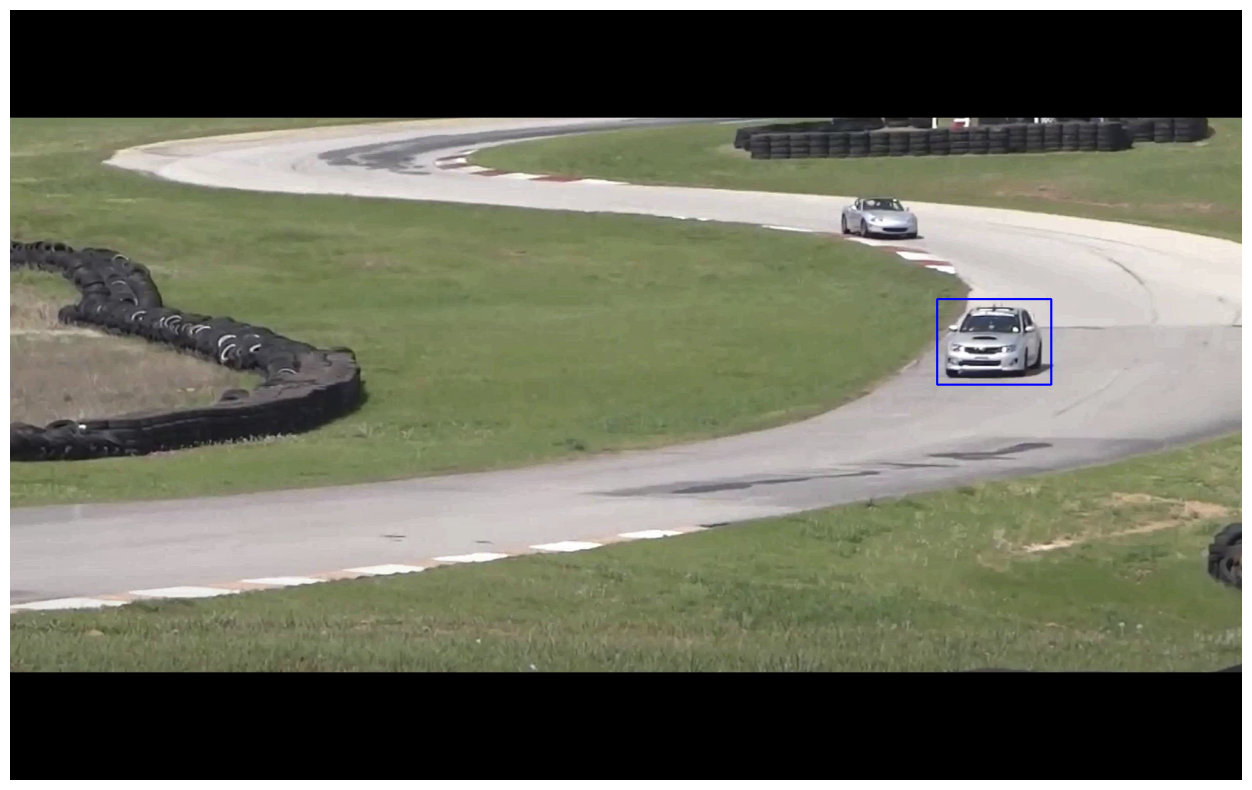

In [9]:
# Define a bounding box
bbox = (1300, 405, 160, 120)
# bbox = cv2.selectROI(frame, False)
# print(bbox)
displayRectangle(frame, bbox)

In [10]:
ok = tracker.init(frame, bbox)

In [11]:
while True:
    ok, frame = video.read()

    if not ok:
        break

    # Start timer
    timer = cv2.getTickCount()

    # Update tracker
    ok, bbox = tracker.update(frame)

    # Calculate Frames per second (FPS)
    fps = cv2.getTickFrequency() / (cv2.getTickCount() - timer)

    # Draw bounding box
    if ok:
        drawRectangle(frame, bbox)
    else:
        drawText(frame, "Tracking failure detected", (80, 140), (0, 0, 255))

    # Display Info
    drawText(frame, tracker_type + " Tracker", (80, 60))
    drawText(frame, "FPS : " + str(int(fps)), (80, 100))

    # Write frame to video
    video_out.write(frame)

video.release()
video_out.release()

In [15]:
import os

ffmpeg_exe_path = os.path.join("ffmpeg", "ffmpeg-7.0.1-essentials_build", "bin", "ffmpeg.exe")
print("FFmpeg executable exists:", os.path.exists(ffmpeg_exe_path))


FFmpeg executable exists: True


In [17]:
video_input_file_name = "race_car-KCF.mp4"  # Replace with your input file name
print("Input video file exists:", os.path.exists(video_input_file_name))


Input video file exists: True


In [18]:
import os
import subprocess
import requests
from zipfile import ZipFile

# Step 1: Download FFmpeg
ffmpeg_url = "https://www.gyan.dev/ffmpeg/builds/ffmpeg-release-essentials.zip"
ffmpeg_zip_path = "ffmpeg.zip"
with requests.get(ffmpeg_url, stream=True) as r:
    r.raise_for_status()
    with open(ffmpeg_zip_path, 'wb') as f:
        for chunk in r.iter_content(chunk_size=8192):
            f.write(chunk)

# Step 2: Extract FFmpeg
with ZipFile(ffmpeg_zip_path, 'r') as zip_ref:
    zip_ref.extractall("ffmpeg")

# Find the extracted FFmpeg directory
ffmpeg_dir = next((d for d in os.listdir("ffmpeg") if os.path.isdir(os.path.join("ffmpeg", d))), None)
if ffmpeg_dir is None:
    raise FileNotFoundError("FFmpeg directory not found after extraction.")

ffmpeg_bin_path = os.path.join("ffmpeg", ffmpeg_dir, "bin")
ffmpeg_exe_path = os.path.join(ffmpeg_bin_path, "ffmpeg.exe")

# Update the PATH environment variable to include the FFmpeg bin directory
os.environ["PATH"] += os.pathsep + ffmpeg_bin_path

# Clean up the zip file
os.remove(ffmpeg_zip_path)

# Step 3: Test FFmpeg installation
subprocess.run([ffmpeg_exe_path, "-version"], check=True)

# Step 4: Change video encoding
video_input_file_name = "race_car-KCF.mp4"  # Replace with your input file name
video_output_file_name = "race_car_track_x264.mp4"

# Run FFmpeg command to change video encoding
ffmpeg_command = [
    ffmpeg_exe_path,
    "-y",
    "-i", video_input_file_name,
    "-c:v", "libx264",
    video_output_file_name,
    "-hide_banner",
    "-loglevel", "error"
]

# Execute the FFmpeg command
subprocess.run(ffmpeg_command, check=True)

print(f"Video encoding changed successfully and saved as {video_output_file_name}")


Video encoding changed successfully and saved as race_car_track_x264.mp4


In [20]:
mp4 = open("race_car_track_x264.mp4", "rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

HTML(f"""<video width=1024 controls><source src="{data_url}" type="video/mp4"></video>""")